In [271]:
import json
import os
import random
import re  # Expresiones regulares
import sys  # Interactuar con el sistema
from itertools import chain, combinations  # Iteradores
from pathlib import Path

import geopandas as gpd  # Georeferenciacion
import matplotlib.pyplot as plt  # Visualización de datos
import numpy as np  # Albegra lineal
import osmnx as ox  # OpenStreetMap
import pandas as pd  # Procesamiento de datos
import scipy.stats as stats
import seaborn as sns  # Visualización de datos estadísticos
import sklearn
import utils
from geopandas.datasets import get_path  # Ruta de los datos geográficos
from scipy.stats import chi2_contingency  # Test de chi-cuadrado
from scipy.stats import pearsonr
from shapely.geometry import Point  # Geometría espacial
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score  # Metricas para evaluación
from sklearn.metrics import (confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from tqdm.notebook import tqdm
from ydata_profiling import ProfileReport

In [243]:
pd.options.mode.chained_assignment = None

set_config(enable_metadata_routing=True)

random_seed = 42
random.seed(random_seed)

main_path = Path.cwd() / ".."
df = pd.read_csv(main_path / "data/weatherAUS.csv")

spectral_palette = [
    "#9e0142",
    "#d53e4f",
    "#f46d43",
    "#fdae61",
    "#fee08b",
    "#ffffbf",
    "#e6f598",
    "#abdda4",
    "#66c2a5",
    "#3288bd",
    "#5e4fa2",
]

---

#### Data cleansing

Eliminamos las observaciones sin ground truth en la variable objetivo, ya que no van a ser necesarias para el entrenamiento (debido a la gran cantidad de observaciones con las que contamos y la relativamente baja proporción de datos faltantes en la variable objetivo), y tampoco nos van a ser útiles para evaluar el modelo ya que en la immputación podemos introducir ciertos sesgos.

In [244]:
print(
    f"Proporción de datos faltantes en la variable objetivo: {round(df.RainTomorrow.isna().mean(), 3)}"
)

Proporción de datos faltantes en la variable objetivo: 0.022


In [245]:
df = df.dropna(subset=["RainTomorrow"])

---

#### Categorical features encoding

##### Rain Today and Rain Tomorrow

In [246]:
rain_columns = ["RainToday", "RainTomorrow"]
mapping_dict = {"Yes" : 1, "No" : 0}

for column in rain_columns:
    df[column] = df[column].map(mapping_dict)

##### Location

In [247]:
# Geolocate stations
country = "Australia"

mapping_dict = {"Dartmoor": "DartmoorVillage", "Richmond": "RichmondSydney"}
df["Location"] = df["Location"].map(mapping_dict).fillna(df["Location"])

locations = df["Location"].unique()
locations = [re.sub(r"([a-z])([A-Z])", r"\1 \2", l) for l in locations]

locs = []
lats = []
lons = []
for location in locations:
    try:
        lat, lon = ox.geocode(location + f", {country}")

        locs.append(location.replace(" ", ""))
        lats.append(lat)
        lons.append(lon)
    except Exception as e:
        print(f"Error retrieving coordinates for {location}: {e}")

df_locations = pd.DataFrame({"Location": locs, "Lat": lats, "Lon": lons})

df = pd.merge(df, df_locations, how="left", on="Location")

##### Date

In [248]:
df["Date"] = pd.to_datetime(df["Date"])

df['DayOfYear'] = df['Date'].dt.dayofyear
df['DaysInYear'] = df['Date'].dt.is_leap_year.apply(lambda leap: 366 if leap else 365)

df['Angle'] = 2 * np.pi * (df['DayOfYear'] - 1) / (df['DaysInYear'])

df['DayCos'] = np.cos(df['Angle'])
df['DaySin'] = np.sin(df['Angle'])

df = df.drop(columns=["DayOfYear", "DaysInYear", "Angle"])

##### Wind Dir

In [249]:
dirs = ["E", "ENE", "NE", "NNE", "N", "NNW", "NW", "WNW", "W", "WSW", "SW", "SSW", "S", "SSE", "SE", "ESE"]
angles = np.radians(np.arange(0, 360, 22.5))
mapping_dict = {d: a for (d, a) in zip(dirs, angles)}

wind_dir_columns = ["WindGustDir", "WindDir9am", "WindDir3pm"]
for column in wind_dir_columns:
    df[f"{column}Angle"] = df[column].map(mapping_dict)

    df[f"{column}Cos"] = np.cos(df[f"{column}Angle"])
    df[f"{column}Sin"] = np.sin(df[f"{column}Angle"])

    df = df.drop(columns=f"{column}Angle")

---

#### Train Test split

Vamos a utilizar una proporción de 0.7|0.15|0.15 para train, validation and test sets respectivamente. Este split no vamos a realizarlo seleccionadas observaciones completamente al azar, sino que por el contrario vamos a considerar todas las observaciones correspondientes a una serie de fechas seleccionadas al azar. Esto nos permitirá evitar el fenómeno de data leaking dado por un modelo que aprenda que en un determinado día y en un determinado sector geográfico hay lluvia al día siguiente (positivo para la clase objetivo) a partir de observaciones para el mismo día en estaciones cercanas entre si. Recordemos que, cómo vimos en el análisis exploratorio de datos, encontramos estaciones meteorológicas muy cercanas entre si con correlaciones cercanas a 0.8 para la probabilidad de lluvia en un mismo día.

In [250]:
def split_list(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of the split ratios must be 1.0")
    
    random.shuffle(data)

    total_size = len(data)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    
    train_set = data[:train_size]
    val_set = data[train_size:(train_size + val_size)]
    test_set = data[(train_size + val_size):]
    
    return train_set, val_set, test_set

In [251]:
list_dates = df["Date"].unique().tolist()
train_dates, val_dates, test_dates = split_list(list_dates)

train_filt = df["Date"].isin(train_dates + val_dates)
train_set = df.loc[train_filt, :].reset_index(drop=True)

test_filt = df["Date"].isin(test_dates)
test_set = df.loc[test_filt, :].reset_index(drop=True)

---

#### Numeric skeweness reduction

In [252]:
train_set_skew = train_set.copy()

numeric_columns = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm"
]

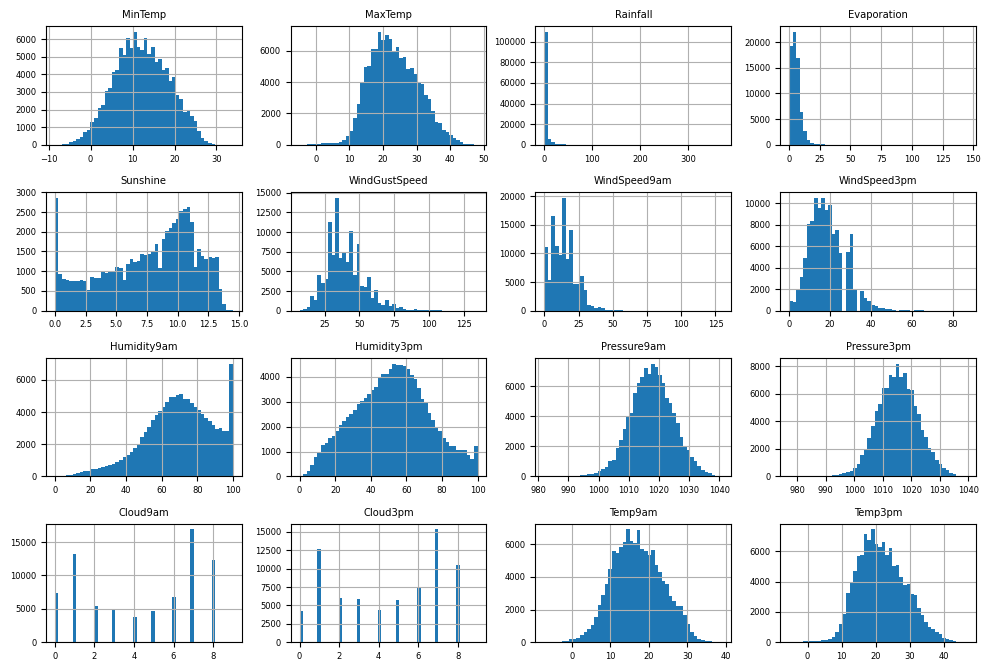

In [253]:
plt.rcParams.update({'font.size': 6})
train_set_skew[numeric_columns].hist(bins=50, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.show()

In [254]:
train_set_skew[numeric_columns].kurtosis(numeric_only=True)

MinTemp           -0.489722
MaxTemp           -0.237807
Rainfall         185.446037
Evaporation       47.464434
Sunshine          -0.825532
WindGustSpeed      1.409267
WindSpeed9am       1.206857
WindSpeed3pm       0.770985
Humidity9am       -0.045800
Humidity3pm       -0.516242
Pressure9am        0.226843
Pressure3pm        0.107626
Cloud9am          -1.542493
Cloud3pm          -1.458780
Temp9am           -0.349470
Temp3pm           -0.145123
dtype: float64

_Cabe remarcar, que la oblicuidad de la variable Rainfall se debe principalmente al desbalanceo del dataset (mayor cantidad de observaciones con clase negativa para las variables RainToday y RainTomorrow) y la relación determinística entre esta variable cuando asume valor 0 y un valor negativo para la variable RainToday._

Vamos a utilizar la función logarítmica en las variables "Rainfall" y "Evaporation" cuya métrica de oblicuidad es mayor a 2.

In [255]:
right_skewed_columns = ["Rainfall", "Evaporation"]
for column in right_skewed_columns:
    train_set_skew[f"{column}Log"] = np.log(train_set_skew[column]+1)

---

#### Numeric outliers handling

In [256]:
train_set_outliers = train_set_skew.copy()

numeric_columns = [
    "MinTemp",
    "MaxTemp",
    "RainfallLog",
    "EvaporationLog",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm"
]

In [257]:
def get_outlier_thresh (x, q1=0.25, q3=0.75) :
    quartile1 = x.quantile(q1)
    quartile3 = x.quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

def cap_outliers(x):
    low_limit , up_limit = get_outlier_thresh(x)

    is_over_limits = x > up_limit
    x[is_over_limits] = up_limit

    is_under_limits = x < low_limit
    x[is_under_limits] = low_limit

    return x

In [258]:
for column in tqdm(numeric_columns):
    train_set_outliers[column] = cap_outliers(train_set_outliers[column])

  0%|          | 0/16 [00:00<?, ?it/s]

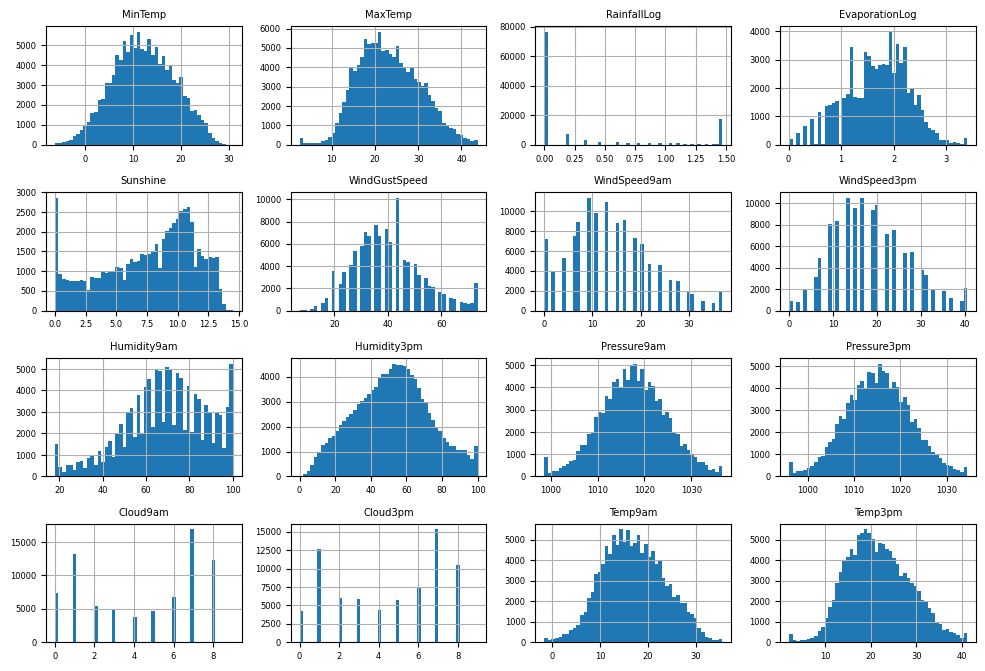

In [259]:
plt.rcParams.update({'font.size': 6})
train_set_outliers[numeric_columns].hist(bins=50, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.show()

---

#### Missing values imputation

Vamos a realizar la imputación de datos faltantes mediante un kn customizado utilizando las observaciones en la misma fecha y en la estación meteorológica con mayor similaridad a un dato faltante.

In [260]:
train_set_missing = train_set_outliers.copy()

index_columns = ["Date", "Location"]

feature_columns = [
    "Lat",
    "Lon",
    "DayCos",
    "DaySin",
    "MinTemp",
    "MaxTemp",
    "RainfallLog",
    "EvaporationLog",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "WindGustDirCos",
    "WindGustDirSin",
    "WindDir9amCos",
    "WindDir9amSin",
    "WindDir3pmCos",
    "WindDir3pmSin",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm",
    "RainToday",
]

target_column = ["RainTomorrow"]

In [261]:
significance_thresh = 0.05
corr_thresh = 0.7

locations = df["Location"].unique()
location_pairs = list(combinations(locations, 2))

numeric_feature_columns = [
    x
    for x in feature_columns
    if x not in ["Lat", "Lon", "DayCos", "DaySin", "RainToday"]
]

spatial_correlations = {}
for feature in tqdm(numeric_feature_columns):
    df_feature = train_set_missing.pivot(index="Date", columns="Location", values=feature)

    feature_correlations = []
    for index, location_pair in enumerate(location_pairs):
        loc_a, loc_b = location_pair
        df_feature_pair = df_feature[[loc_a, loc_b]].dropna()
        if not df_feature_pair.empty:
            corr, pvalue = pearsonr(df_feature_pair[loc_a], df_feature_pair[loc_b])

            if (pvalue < significance_thresh) & (corr > corr_thresh):
                ridge = Ridge(alpha=1.0)
                ridge.fit(df_feature_pair[loc_a].values.reshape(-1, 1), df_feature_pair[loc_b])
                intercept = ridge.intercept_
                coeficient = ridge.coef_[0]

                pair_correlation = {}
                pair_correlation["loc_a"] = loc_a
                pair_correlation["loc_b"] = loc_b
                pair_correlation["corr"] = corr
                pair_correlation["intercept"] = intercept
                pair_correlation["slope"] = coeficient
                feature_correlations.append(pair_correlation.copy())

                pair_correlation_inv = {}
                pair_correlation_inv["loc_a"] = loc_b
                pair_correlation_inv["loc_b"] = loc_a
                pair_correlation_inv["corr"] = corr
                pair_correlation_inv["intercept"] = -1 * intercept / coeficient
                pair_correlation_inv["slope"] = 1 / coeficient
                feature_correlations.append(pair_correlation_inv.copy())

    df_feature_correlations = pd.DataFrame(feature_correlations)
    spatial_correlations[feature] = df_feature_correlations

  0%|          | 0/22 [00:00<?, ?it/s]

In [262]:
def impute_missing(df, date, location, feature, correlations, k):
    filt = correlations["loc_b"] == location
    correlations = correlations.loc[filt, :]

    filt = (
        (df["Date"] == date)
        & (df["Location"].isin(correlations["loc_a"]))
        & (~df[feature].isna())
    )
    if filt.sum() == 0:
        return np.nan
    df_nearests = df.loc[filt, :]

    df_nearests = (
        pd.merge(
            df_nearests[["Date", "Location", feature]],
            correlations[["loc_a", "corr", "intercept", "slope"]],
            how="left",
            left_on="Location",
            right_on="loc_a",
        )
        .sort_values(by="corr", ascending=False)
        .head(3)
    )

    df_nearests["y"] = (
        df_nearests[feature] * df_nearests["slope"] + df_nearests["intercept"]
    )

    imputed = (df_nearests["y"] * (df_nearests["corr"] ** 2)).sum() / (
        df_nearests["corr"] ** 2
    ).sum()

    min_value = df[feature].min()
    max_value = df[feature].max()
    imputed = imputed if imputed > min_value else min_value
    imputed = imputed if imputed < max_value else max_value

    return imputed

In [263]:
for feature in tqdm(numeric_feature_columns):
    feature_locations = spatial_correlations[feature]["loc_a"].unique()

    filt = (train_set_missing[feature].isna()) & (train_set_missing["Location"].isin(feature_locations))
    train_set_missing.loc[filt, feature] = train_set_missing.loc[filt, :].apply(
        lambda x: impute_missing(
            df=train_set_missing,
            date=x["Date"],
            location=x["Location"],
            feature=feature,
            correlations=spatial_correlations[feature],
            k=3,
        ),
        axis=1,
    )

  0%|          | 0/22 [00:00<?, ?it/s]

In [264]:
angle_feature_columns = [
    ("WindGustDirCos", "WindGustDirSin"),
    ("WindDir9amCos", "WindDir9amSin"),
    ("WindDir3pmCos", "WindDir3pmSin"),
]

for angle_feature_cos, angle_feature_sin in tqdm(angle_feature_columns):
    magnitude = np.sqrt(train_set_missing[angle_feature_cos]**2 + train_set_missing[angle_feature_sin]**2)
    train_set_missing[angle_feature_cos] = train_set_missing[angle_feature_cos] / magnitude
    train_set_missing[angle_feature_sin] = train_set_missing[angle_feature_sin] / magnitude

  0%|          | 0/3 [00:00<?, ?it/s]

In [265]:
prop_imputed = round(1-(train_set_missing.isna().sum().sum() / train_set_outliers.isna().sum().sum()), 3)
print(f"Proporción de datos faltantes imputados por técnica de cercanía física: {prop_imputed}")

Proporción de datos faltantes imputados por técnica de cercanía física: 0.089


Vamos a imputar los datos aún faltantes utilizando el algoritmo MICE.

In [266]:
missing_scaler = StandardScaler()
X_missing_scaled = missing_scaler.fit_transform(train_set_missing[numeric_feature_columns])

In [267]:
min_values = np.array(
    [train_set_missing[column].min() for column in numeric_feature_columns]
)
max_values = np.array(
    [train_set_missing[column].max() for column in numeric_feature_columns]
)

iterative_imputer = IterativeImputer(
    initial_strategy="median",
    min_value=min_values,
    max_value=max_values,
    random_state=random_seed,
    keep_empty_features=True,
)
X_imputed_scaled = iterative_imputer.fit_transform(
    X_missing_scaled,
)

In [268]:
X_imputed = missing_scaler.inverse_transform(X_imputed_scaled)
train_set_missing[numeric_feature_columns] = X_imputed

In [269]:
angle_feature_columns = [
    ("WindGustDirCos", "WindGustDirSin"),
    ("WindDir9amCos", "WindDir9amSin"),
    ("WindDir3pmCos", "WindDir3pmSin"),
]

for angle_feature_cos, angle_feature_sin in tqdm(angle_feature_columns):
    magnitude = np.sqrt(train_set_missing[angle_feature_cos]**2 + train_set_missing[angle_feature_sin]**2)
    train_set_missing[angle_feature_cos] = train_set_missing[angle_feature_cos] / magnitude
    train_set_missing[angle_feature_sin] = train_set_missing[angle_feature_sin] / magnitude

  0%|          | 0/3 [00:00<?, ?it/s]

---

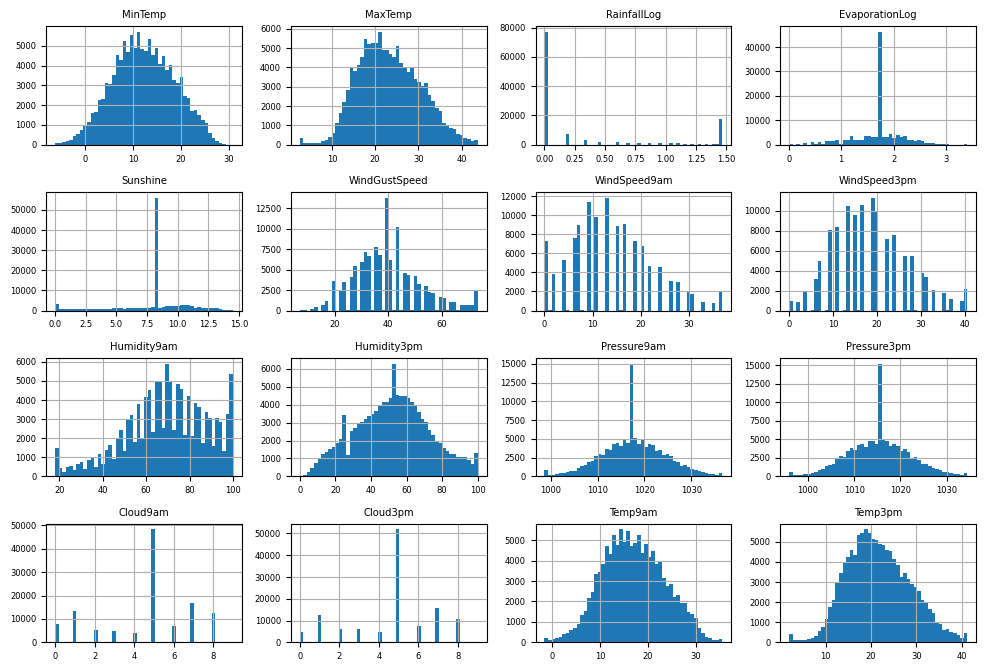

In [270]:
plt.rcParams.update({'font.size': 6})
train_set_missing[numeric_columns].hist(bins=50, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.show()

---

#### Target class balancing

In [288]:
train_set_resampled = train_set_missing.copy()[feature_columns + target_column]

In [289]:
filt = train_set_resampled["RainTomorrow"].astype(bool)
positive_class = train_set_resampled.loc[filt, :]
negative_class = train_set_resampled.loc[~filt, :]

In [290]:
positive_class_oversampled = resample(
    positive_class,
    replace=True,
    n_samples=negative_class.shape[0],
    random_state=random_seed,
)

train_set_resampled = pd.concat([positive_class_oversampled, negative_class]).reset_index(drop=True)

---

#### Train model

In [295]:
X = train_set_resampled[feature_columns].values
y = train_set_resampled[target_column].values

In [297]:
y

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int64)